In [1]:
import pandas as pd
import seaborn as sns
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.collections
from typing import *
import math
import json
from utils import dref_dataframe, dref_dataframe_multi

sns.set_style("whitegrid")
#sns.set_context("poster", font_scale=0.75)
sns.set_context("poster", font_scale=1.3)
sns.set_palette("colorblind6")

def set_plt_font_size(size: int = 16):
    return
    #plt.rc('font', size=size)
    #plt.rc('axes', titlesize=size)
    #plt.rc('axes', labelsize=size)
    #plt.rc('xtick', labelsize=size)
    #plt.rc('ytick', labelsize=size)
    #plt.rc('legend', fontsize=size)
    #plt.rc('figure', titlesize=size)
    #sns.set_theme(font_scale=2)

def plot_core_configs(cores: list[int], do_plot: Callable[[int, any], plt.Axes]) -> plt.Figure:
    ncores = len(cores)
    ncols = 3
    nrows = math.ceil(ncores / float(ncols))
    if nrows == 1:
        ncols = ncores
    fig, axes = plt.subplots(nrows, ncols, figsize=(10 * ncols, 7.5 * nrows))
    for i, c in enumerate(cores):
        col = i % ncols
        ax = axes[col] if nrows == 1 else axes[i // ncols, col]
        f = do_plot(c, ax)
        if col != 0:
            f.set_ylabel("")

    return fig

def calc_stats(data: pd.DataFrame, cores: list[int], data_col: str) -> pd.DataFrame:
    rows = []
    for c in cores:
        core_data = data.loc[data["Cores"] == c]
        for d in ["virtio-balloon", "virtio-balloon-huge", "virtio-mem", "llfree", "llfree-vfio"]:
            driver_data = core_data.loc[core_data["Driver"] == d]
            std = driver_data[data_col].std()
            mean = driver_data[data_col].mean()
            rows.append({"Cores":c, "Driver":d, "Mean":mean, "Std":std})

    return pd.DataFrame(rows)

def render_plt(fig, name: str, path: Path = Path("stream")):
    fig.savefig(path / f"{name}.pdf", bbox_inches="tight", dpi=100)

In [2]:
def load_stream_csv(p: Path, cores: int, driver: str) -> pd.DataFrame:
    data = pd.read_csv(p / f"{driver}-stream" / str(cores) / "Copy.csv")
    times = data["IterTime"]
    t_sum = 0.0
    for i in range(0, len(times)):
        t_sum += times[i]
        times[i] = t_sum

    data["Bandwidth"] /= 1000.0
    return data.assign(Cores=cores, Driver=driver)

def load_streams(p: Path, cores: list[int], max_t: float = 140.0) -> pd.DataFrame:
    frames = []
    for c in cores:
        base = load_stream_csv(p, c, "virtio-balloon")
        retained_samples = next((i for i, t in enumerate(base["IterTime"]) if t >= max_t), len(base["IterTime"]))
        frames.append(base.head(retained_samples))
        for d in ["virtio-mem-vfio", "virtio-mem", "virtio-balloon-huge", "llfree", "llfree-vfio"]:
            frames.append(load_stream_csv(p, c, d).head(retained_samples))

    return pd.concat(frames)

stream = load_streams(Path("stream/latest"), [1, 2, 4, 8, 10, 12])
dref_dataframe("stream", Path("stream"), ["Driver", "Cores", "IterTime"], stream)

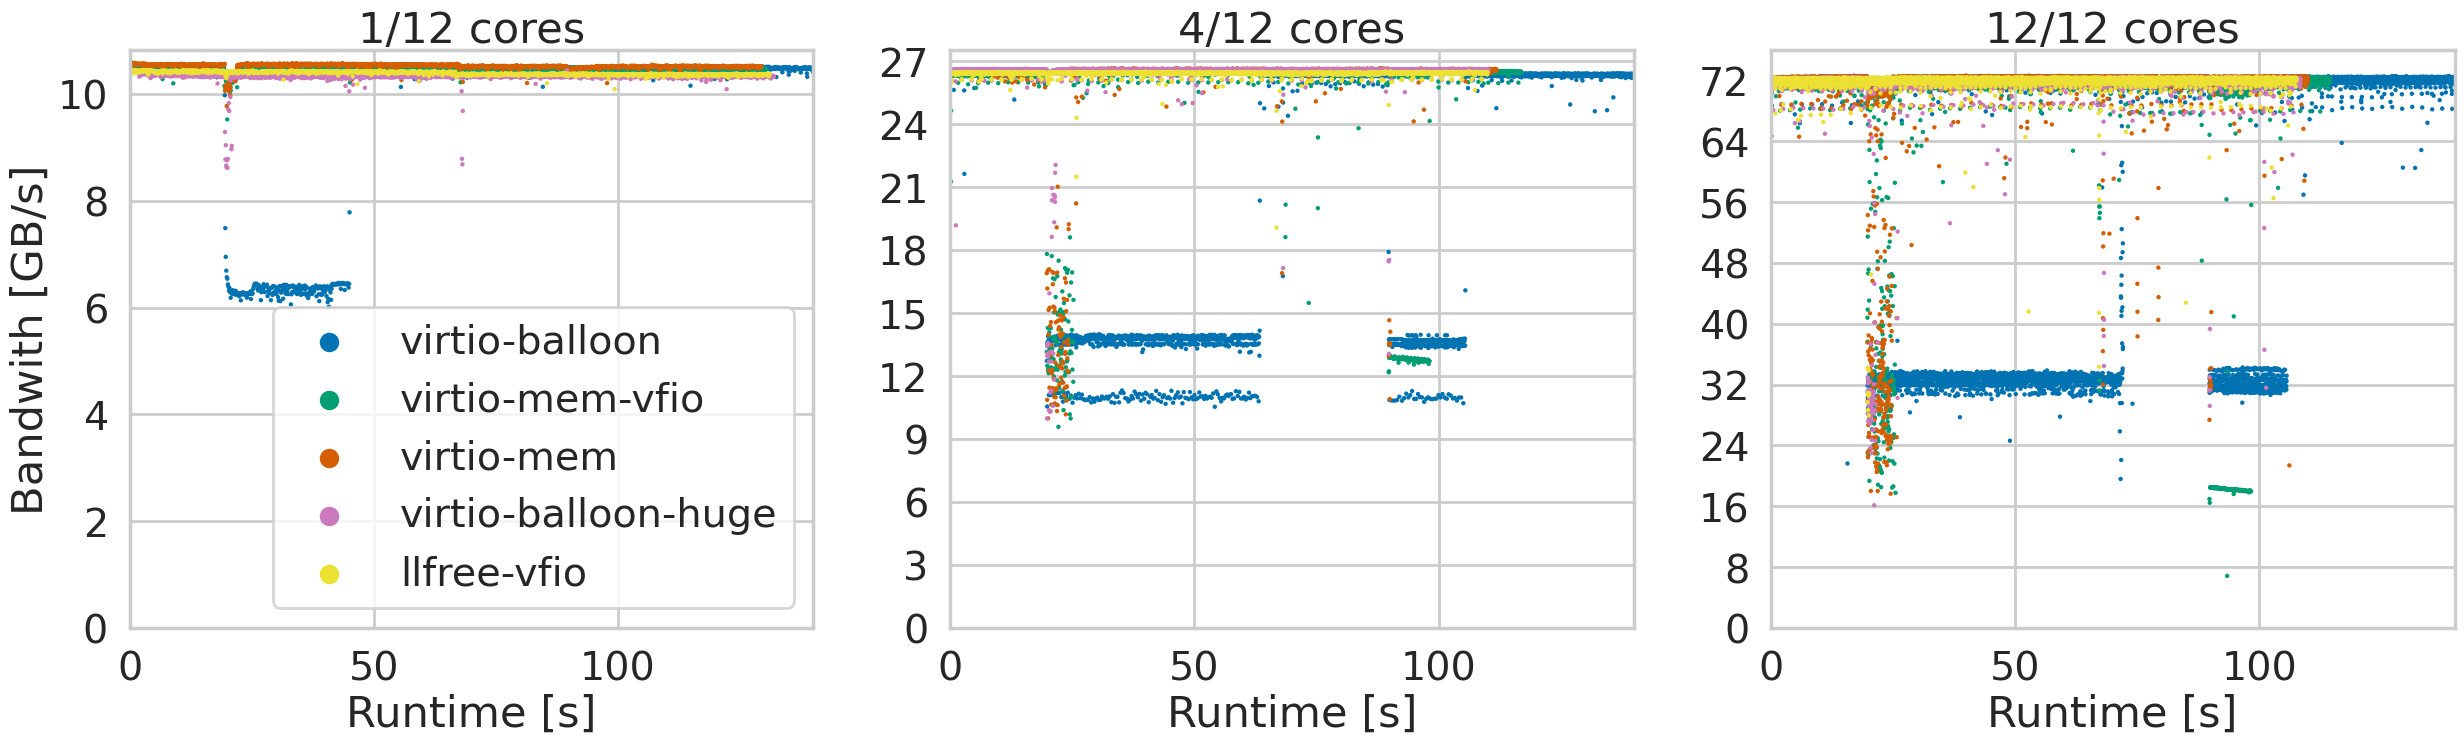

In [3]:

def plot_stream(cores: int, axis: any) -> plt.Axes:
    d = stream.loc[stream["Cores"] == cores]
    d = d.loc[d["Driver"] != "llfree"]
    plot = sns.scatterplot(x="IterTime", y="Bandwidth", data=d, hue="Driver", s=10.0, ax=axis, linewidth=0)
    plot.set_xlim(0.0, 140.0)
    plot.set_ylim(0.0)
    axis.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    plot.set_ylabel("Bandwith [GB/s]")
    plot.set_xlabel("Runtime [s]")
    plot.set_title(f"{cores}/12 cores")
    plot.legend(loc="lower right")
    plot.get_legend().set_visible(cores == 1)
    plot.get_legend().set_title("")
    for c in plot.get_children():
        if isinstance(c, matplotlib.collections.PathCollection):
            c.set_rasterized(True)
    return plot

#plot_core_configs([1, 2, 4, 8, 10, 12], plot_stream)
fig = plot_core_configs([1, 4, 12], plot_stream)
render_plt(fig, "stream")

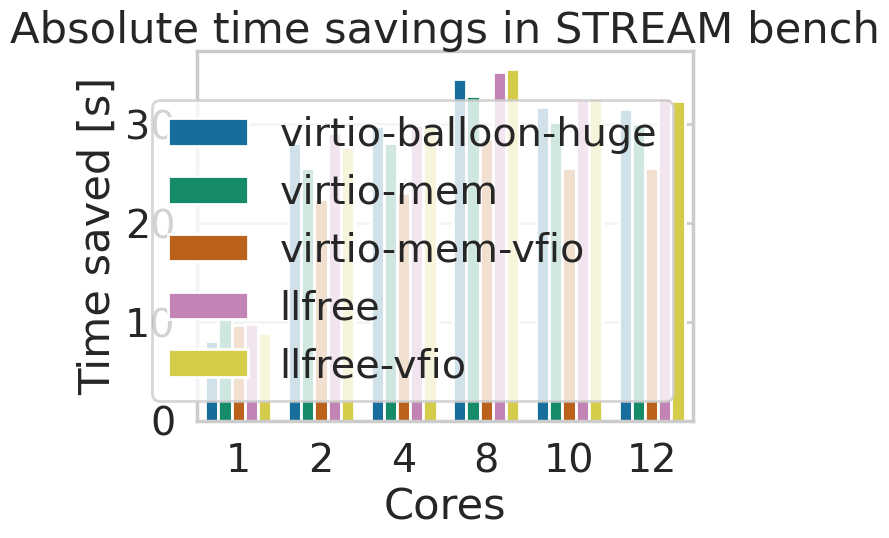

In [4]:
def calc_stream_speedz(cores: list[int]) -> pd.DataFrame:
    frames = []
    drivers = ["virtio-balloon-huge", "virtio-mem", "virtio-mem-vfio", "llfree", "llfree-vfio"]
    for c in cores:
        core_data = stream.loc[stream["Cores"] == c]
        virtio_balloon = core_data.loc[core_data["Driver"] == "virtio-balloon"]
        long_time = virtio_balloon["IterTime"][len(virtio_balloon["IterTime"]) - 1]
        times = []
        for driver in drivers:
            driver_data = core_data.loc[core_data["Driver"] == driver]
            times.append(long_time - driver_data["IterTime"][len(long_time - driver_data["IterTime"])-1])

        frames.append(pd.DataFrame({"Faster": times, "Driver": drivers}).assign(Cores=c))

    return pd.concat(frames)


stream_speedz = calc_stream_speedz([1, 2, 4, 8, 10, 12])
dref_dataframe("stream-speed", Path("stream"), ["Cores", "Driver"], stream_speedz)

plot = sns.barplot(data=stream_speedz, x="Cores", y="Faster", hue="Driver")
plot.set_ylabel("Time saved [s]")
plot.set_xlabel("Cores")
plot.set_title(f"Absolute time savings in STREAM bench")
plot.get_legend().set_title("")
sns.move_legend(plot, "lower right")

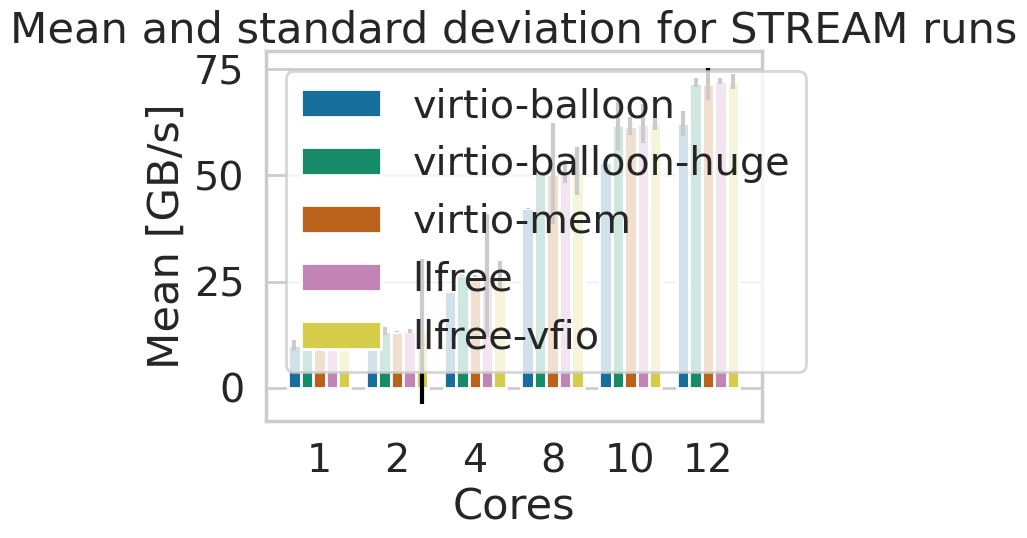

In [5]:
stream_stats = calc_stats(stream, [1, 2, 4, 8, 10, 12], "Bandwidth")
dref_dataframe_multi("stream-stats", Path("stream"), ["Cores", "Driver"], ["Mean", "Std"], stream_stats)
plot = sns.barplot(data=stream_stats, x="Cores", y="Mean", hue="Driver")
x_coords = [p.get_x() + 0.5 * p.get_width() for p in plot.patches]
y_coords = [p.get_height() for p in plot.patches]
plot.errorbar(x=x_coords, y=y_coords, yerr=stream_stats["Std"], fmt="none", c="k")
plot.set_ylabel("Mean [GB/s]")
plot.set_xlabel("Cores")
plot.set_title(f"Mean and standard deviation for STREAM runs")
plot.get_legend().set_title("")
sns.move_legend(plot, "upper left")

In [6]:
def sum_ftqs_batched(path: Path, cores: int, driver: str, samples: int) -> pd.DataFrame:
    p = path / f"{driver}-ftq" / str(cores)
    out = pd.DataFrame()
    counts = list(map(lambda s: int(s), (p / "counts.dat").read_text().splitlines()))
    times = list(map(lambda s: int(s), (p / "times.dat").read_text().splitlines()))
    for i in range(0, cores):
        data = pd.DataFrame()
        data["Times"] = times[(samples*i):(samples*(i+1))]
        data["Counts"] = counts[(samples*i):(samples*(i+1))]
        if i == 0:
            out = data
        else:
            out["Counts"] += data["Counts"]
    start_cycle = out["Times"][0]
    out["Times"] -= start_cycle
    return out.tail(-1).assign(Cores=cores, Driver=driver)

def load_ftqs(p: Path, cores: list[int]) -> pd.DataFrame:
    frames = []
    for c in cores:
        for d in ["virtio-balloon", "virtio-mem-vfio", "virtio-mem", "virtio-balloon-huge", "llfree", "llfree-vfio"]:
            frames.append(sum_ftqs_batched(p, c, d, 1096))

    return pd.concat(frames)

ftq = load_ftqs(Path("stream/latest"), [1, 2, 4, 8, 10, 12])
dref_dataframe("ftq", Path("stream"), ["Driver", "Cores", "Times"], ftq)

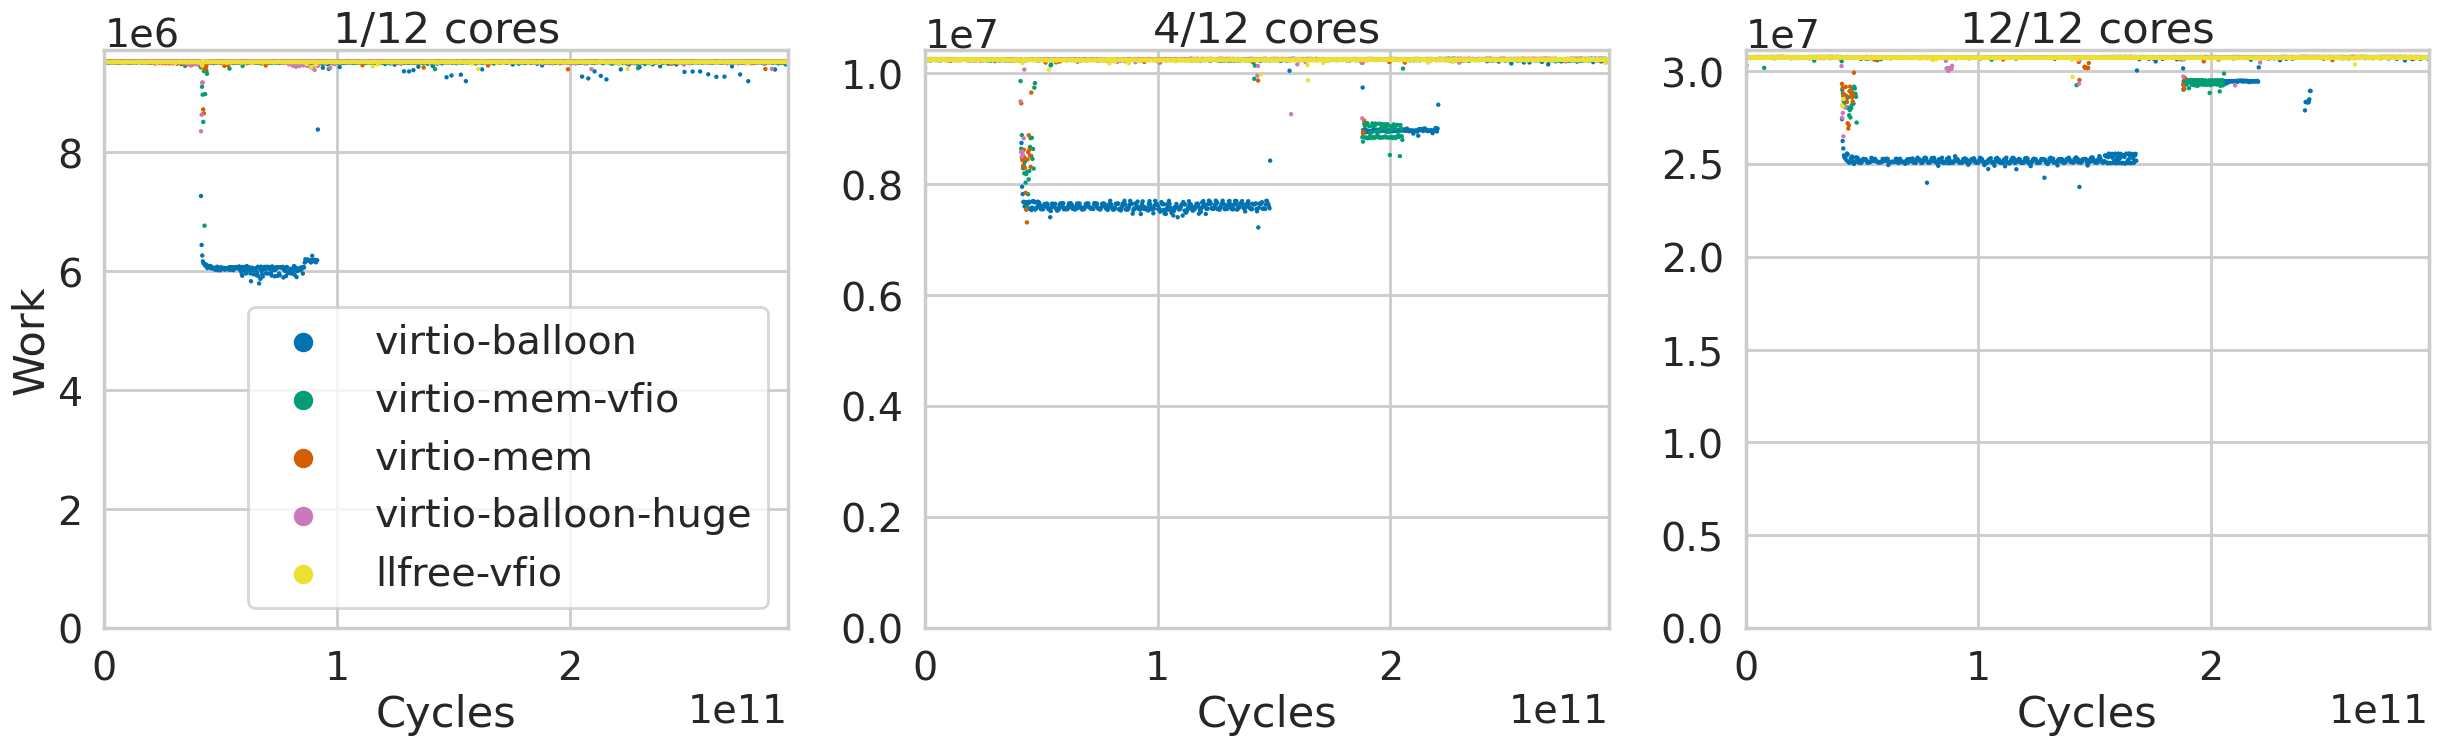

In [7]:
def plot_ftq(cores: int, axis: any) -> plt.Axes:
    d = ftq.loc[ftq["Cores"] == cores]
    d = d.loc[d["Driver"] != "llfree"]
    plot = sns.scatterplot(x="Times", y="Counts", data=d, hue="Driver", s=10.0, ax=axis, linewidth=0)
    plot.set_ylim(0.0)
    plot.set_xlim(0.0, d["Times"].iloc[-1])
    plot.set_ylabel("Work")
    plot.set_xlabel("Cycles")
    plot.set_title(f"{cores}/12 cores")
    plot.legend(loc="lower right")
    plot.get_legend().set_visible(cores == 1)
    plot.get_legend().set_title("")
    for c in plot.get_children():
        if isinstance(c, matplotlib.collections.PathCollection):
            c.set_rasterized(True)
    return plot

fig = plot_core_configs([1, 4, 12], plot_ftq)
render_plt(fig, "ftq")

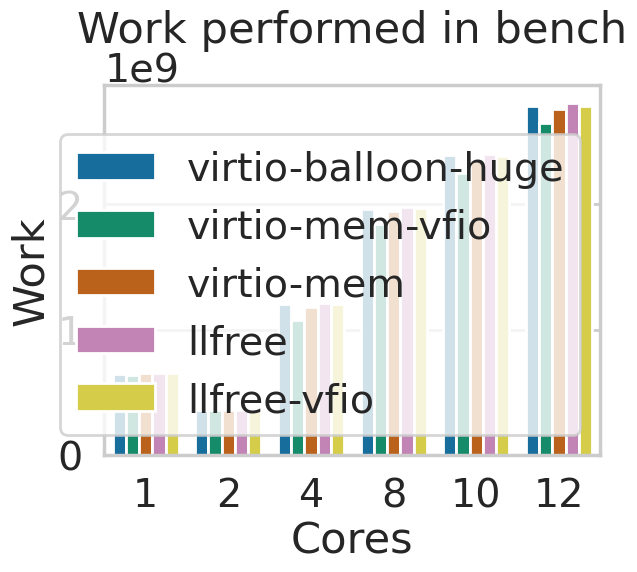

In [8]:
def calc_ftq_speedz(cores: list[int]) -> pd.DataFrame:
    frames = []
    drivers = ["virtio-balloon-huge", "virtio-mem-vfio", "virtio-mem", "llfree", "llfree-vfio"]
    for c in cores:
        core_data = ftq.loc[ftq["Cores"] == c]
        base = core_data.loc[core_data["Driver"] == "virtio-balloon"]["Counts"].sum()
        work = []
        for driver in drivers:
            driver_data = core_data.loc[core_data["Driver"] == driver]
            work.append(driver_data["Counts"].sum() - base)

        frames.append(pd.DataFrame({"Work": work, "Driver": drivers}).assign(Cores=c))

    return pd.concat(frames)


ftq_speedz = calc_ftq_speedz([1, 2, 4, 8, 10, 12])
dref_dataframe("ftq-speed", Path("stream"), ["Cores", "Driver"], ftq_speedz)

plot = sns.barplot(data=ftq_speedz, x="Cores", y="Work", hue="Driver")
plot.set_ylabel("Work")
plot.set_xlabel("Cores")
plot.set_title(f"Work performed in bench")
plot.get_legend().set_title("")
sns.move_legend(plot, "lower right")

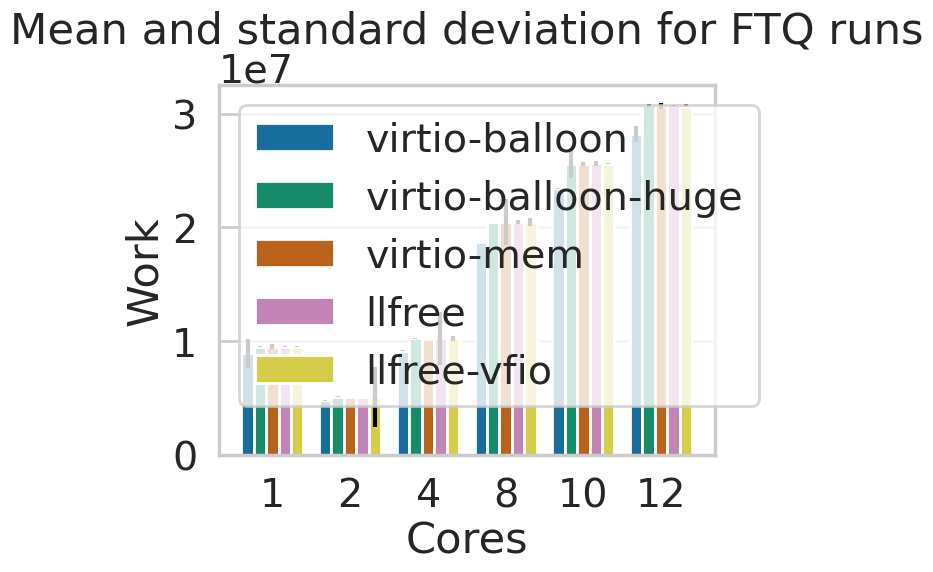

In [9]:
ftq_stats = calc_stats(ftq, [1, 2, 4, 8, 10, 12], "Counts")
dref_dataframe_multi("ftq-stats", Path("stream"), ["Cores", "Driver"], ["Mean", "Std"], ftq_stats)
plot = sns.barplot(data=ftq_stats, x="Cores", y="Mean", hue="Driver")
x_coords = [p.get_x() + 0.5 * p.get_width() for p in plot.patches]
y_coords = [p.get_height() for p in plot.patches]
plot.errorbar(x=x_coords, y=y_coords, yerr=ftq_stats["Std"], fmt="none", c="k")
plot.set_ylabel("Work")
plot.set_xlabel("Cores")
plot.set_title(f"Mean and standard deviation for FTQ runs")
plot.get_legend().set_title("")
sns.move_legend(plot, "upper left")